## The verdict text

Importing the text which we are going to work with

In [1]:
import urllib.request

url= ("https://raw.githubusercontent.com/rasbt/"
      "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
      "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x1ccff1a6a50>)

In [2]:
with open(file_path, "r", encoding="utf-8") as file:
    raw_text = file.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


## Preprocessing text

When we are using regular expressions to treat texts, you have to separate special characters such as commas and puntaction form the words. Moreover, we refrain from making all text lower-case because capitalization helps LLMs distinghish between proper nouns and common nouns, undertand sentence structure,and learn to generate text with proper capitalization. Finally removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing).

In [3]:
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [4]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## Let's map each word with an unique ID

In [5]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [6]:
vocab = {token:integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
  print(item)
  if i>= 50:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


## Implement fo complete tokenizer class

Encode and decode

In [7]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
    """
    Stores the vocabulary as a class attribute
    for access in the encode and decode methods
    """
    self.str_to_int = vocab
    """
    Creates an inverse vocabulary that maps vocabulary
    token IDs back to the original text tokens
    """
    self.int_to_str = {i:s for s,i in vocab.items()}

  def encode(self, text):
    """
    Processes input text into token IDs
    """
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    preprocessed = [item.strip() for item in preprocessed if item.strip()]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  def decode(self, ids):
    """
    Convert token IDs back into text
    """
    text = " ".join([self.int_to_str[i] for i in ids])
    """
    Removes spaces before the specified punctuation
    """
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [8]:
tokenizer = SimpleTokenizerV1(vocab)
text =""""It's the last he painted, you know,"
      Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [9]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


## Special context tokens

We will test tokenizer further on text that contains unknow words and discuss additional special tokens that can be used to provide further context for an LLM durin training.

In [10]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer, token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [11]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [12]:
class SimpleTokenizerV2:
    def __init__(self,vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        """
        Replaces unknown words by <|unk|> tokens
        """
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]

        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Comparing versions of tokenizer

In [13]:
text1 = "hello, do you like tea?"
text2 = "In the sunlit terrace of the palace."
text =  " <|endoftext|> ".join((text1, text2))

print(text)

hello, do you like tea? <|endoftext|> In the sunlit terrace of the palace.


In [14]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 983, 722, 988, 1131, 7]


In [15]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terrace of the <|unk|>.


* [BOS] (_beginning of sequence_)
* [EOS] (_end of sequence_) similar to <|endoftext|>
* [PAD] (_padding_) When training LLMs with batch sizes. To ensure all texts have the same lenght.

GPT models does not need any of these tokens. It only uses <|endoftext|>, is also used for padding. We'll explore when training on batched inputs, we typically use a mask.

Moreover, the tokenizer used for GPT models also doesn't use <|unk|> token for out-of-vocabulary words. Instead, GPT models use a _byte pair encoding tokenizer_.

## Byte pair encoding (BPE)

In [16]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.12.0


In [17]:
tokenizer = tiktoken.get_encoding("gpt2")

The use of this tokenizer is similar to the _SimpleTokenizerV2_ we implemented previously via an _encode_ method

In [18]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    " of someunkonwnPlace."
)
intergers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(intergers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 2954, 261, 675, 27271, 13]


In [19]:
num_words = len(text.split())
print(f"Number of words: {num_words}")
print(f"Number of tokens: {len(intergers)}")

Number of words: 12
Number of tokens: 22


In [20]:
strings = tokenizer.decode(intergers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunkonwnPlace.


The algorithm underlying BPE breaks down words tjat aren't in its predefinided vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. So, thanks to BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as sequence of subword tokens or characters.

### Excercise 2.1

In [21]:
excersice = ("Akwirw ier")
tokens_e = tokenizer.encode(excersice, allowed_special=set())
print(tokens_e)

[33901, 86, 343, 86, 220, 959]


In [22]:
strings_emap = [tokenizer.decode([token]) for token in tokens_e]
print(strings_emap)

['Ak', 'w', 'ir', 'w', ' ', 'ier']


In [23]:
strings_e = tokenizer.decode(tokens_e)
print(strings_e)

Akwirw ier


## Figure 2.1 coded

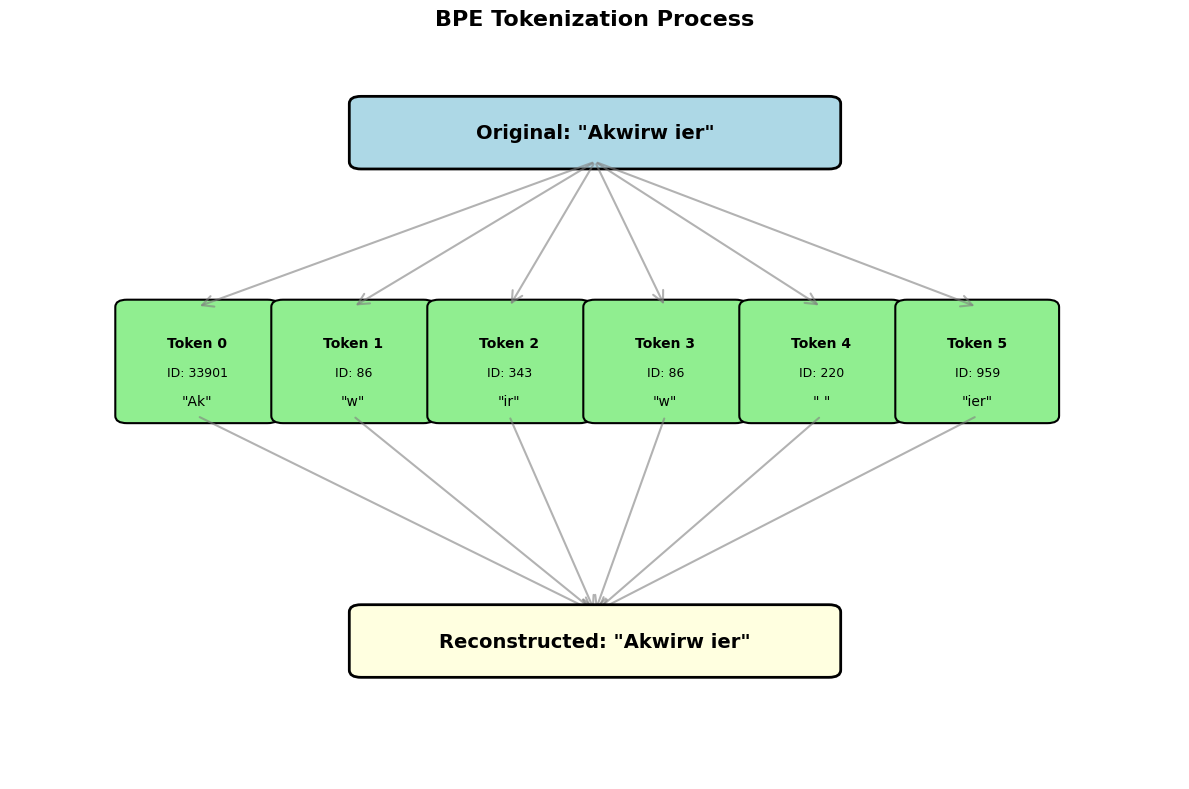

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

exercise = "Akwirw ier"
tokens_e = tokenizer.encode(exercise, allowed_special=set())
strings_emap = [tokenizer.decode([token]) for token in tokens_e]
reconstructed = tokenizer.decode(tokens_e)

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Original text (top)
ax.add_patch(FancyBboxPatch((3, 8.5), 4, 0.8, boxstyle="round,pad=0.1", 
                             facecolor='lightblue', edgecolor='black', linewidth=2))
ax.text(5, 8.9, f'Original: "{exercise}"', ha='center', va='center', 
        fontsize=14, fontweight='bold')

# Token level (middle)
num_tokens = len(tokens_e)
x_positions = [1 + i * (8 / num_tokens) for i in range(num_tokens)]

for i, (x, token_id, token_str) in enumerate(zip(x_positions, tokens_e, strings_emap)):
    # Token box
    ax.add_patch(FancyBboxPatch((x, 5), 1.2, 1.5, boxstyle="round,pad=0.1",
                                 facecolor='lightgreen', edgecolor='black', linewidth=1.5))
    ax.text(x + 0.6, 6, f'Token {i}', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(x + 0.6, 5.6, f'ID: {token_id}', ha='center', va='center', fontsize=9)
    ax.text(x + 0.6, 5.2, f'"{token_str}"', ha='center', va='center', fontsize=10)
    
    # Arrow from original to token
    arrow = FancyArrowPatch((5, 8.5), (x + 0.6, 6.5),
                           arrowstyle='->', mutation_scale=20, linewidth=1.5,
                           color='gray', alpha=0.6)
    ax.add_patch(arrow)
    
    # Arrow from token to reconstructed
    arrow2 = FancyArrowPatch((x + 0.6, 5), (5, 2.3),
                            arrowstyle='->', mutation_scale=20, linewidth=1.5,
                            color='gray', alpha=0.6)
    ax.add_patch(arrow2)

# Reconstructed text (bottom)
ax.add_patch(FancyBboxPatch((3, 1.5), 4, 0.8, boxstyle="round,pad=0.1",
                             facecolor='lightyellow', edgecolor='black', linewidth=2))
ax.text(5, 1.9, f'Reconstructed: "{reconstructed}"', ha='center', va='center',
        fontsize=14, fontweight='bold')

plt.title('BPE Tokenization Process', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('tokenization_tree.png', dpi=300, bbox_inches='tight')
plt.show()

## Input-target pairs

In [25]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [26]:
# Get a sample of the encoded text starting from the 50th token
enc_sample = enc_text[50:]

One of the easiest and most intuitive ways to create the input-traget pairs for the next word prediction task is to create two variables, x na y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1

In [27]:
#The context size determines how many tokens are included in the input
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y: {y}")

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


In [28]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---> ", desired)

[290] --->  4920
[290, 4920] --->  2241
[290, 4920, 2241] --->  287
[290, 4920, 2241, 287] --->  257


In [29]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---> ", tokenizer.decode([desired]))

 and --->   established
 and established --->   himself
 and established himself --->   in
 and established himself in --->   a


We are interested in returning two tensors: an input tensor containing the text that the LLM sees and a target tensor that includes the targets for the LLM to predict.

## Data Loader

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #Tokenizes the entire text
        token_ids = tokenizer.encode(txt)

        #Uses a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    #Return the total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    #Returns a single row from the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [31]:
def create_data_loader_v1(txt, batch_size=4, max_length=256,
                          stride=128, shuffle=True, drop_last=True,
                          num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    #Creates the dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        #drop_last=True drops the last batch if it is shorter than the specified batch size to prevent loss spikes during training
        drop_last=drop_last,
        #The number of CPU processes to use for preprocessing
        num_workers=num_workers
    )

    return dataloader

In [32]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

data_loader = create_data_loader_v1(
    raw_text,
    batch_size=1,
    max_length=4,
    stride=1,
    shuffle=False
)

data_iter = iter(data_loader)
firts_batch = next(data_iter)
print(firts_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [33]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


Exercise 2.2

In [34]:
data_loader = create_data_loader_v1(
    raw_text,
    batch_size=1,
    max_length=2,
    stride=2,
    shuffle=True
)

def comparative_batches(data_loader):
    data_iter = iter(data_loader)
    batch1 = next(data_iter)
    batch2 = next(data_iter)

    print("Batch 1 - Inputs:\n", batch1[0])
    print("Batch 1 - Targets:\n", batch1[1])
    print("\nBatch 2 - Inputs:\n", batch2[0])
    print("Batch 2 - Targets:\n", batch2[1])
 
comparative_batches(data_loader)

Batch 1 - Inputs:
 tensor([[8491,  345]])
Batch 1 - Targets:
 tensor([[ 345, 1654]])

Batch 2 - Inputs:
 tensor([[ 257, 9254]])
Batch 2 - Targets:
 tensor([[9254,  286]])


In [35]:
data_loader = create_data_loader_v1(
    raw_text,
    batch_size=1,
    max_length=8,
    stride=2,
    shuffle=False
)

comparative_batches(data_loader)

Batch 1 - Inputs:
 tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]])
Batch 1 - Targets:
 tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])

Batch 2 - Inputs:
 tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]])
Batch 2 - Targets:
 tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])


In [36]:
dataloader = create_data_loader_v1(
    raw_text,
    batch_size=8,
    max_length=4,
    stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("Targets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## Creating token embeddings

In [37]:
input_ids = torch.tensor([2,3,5,1])

vocab_size = 6
output_dim = 3

In [39]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [41]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [42]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Encoding word positions

In principle, the deterministic, position-independent embedding of the token ID is good for reproducibility purposes. However, since the self-attention mechanism of LLMs itself is also position-agnostic, it is helpful to inject additional position information into the LLM

To achieve this, we can use two broad categories of position-aware embeddings: relative positional mebeddings and absolute positional embeddings. Absolute positional embeddings are directly associated with specific positions in a sequence. For each position in the input sequence, a unique embedding is added to the token's embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on. 

Relative positional embeddings is on the relative position or distance between tokens. The model learns the relationships in terms of "how far apart" rahter than "at which exact position". The advantage here is that the model can generalize better to sequences of varying lengths, even if ti hasn't seen such lengths during training.

OpenAi's GPT models use absolute positional embeddings that are optimized during the training process rather than being fixed or predifined like the positional encodigns in the original transformer model.

In [43]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [44]:
max_length = 4
dataloader = create_data_loader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [45]:
token_embeddings = token_embedding_layer(inputs)
print("Token Embeddings shape:\n", token_embeddings.shape)

Token Embeddings shape:
 torch.Size([8, 4, 256])


For GPT models's absolute embedding approach, we just need to create another embedding layer that has the same embeddings dimension as the _token_embedding_layer_

In [46]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [47]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
